In [2]:
import sys
sys.path.append('.\Tweezer_design\Tweezer_design')

In [12]:
import geometry1 as g0
import IDT_group_toolbox as IDT_gtool
import numpy as np
import math
import warnings
from scipy.optimize.nonlin import NoConvergence
import pickle
import matplotlib.pyplot as plt

In [98]:
from importlib import reload
# reload(g0)
reload (IDT_gtool)

<module 'IDT_group_toolbox' from '.\\Tweezer_design\\Tweezer_design\\IDT_group_toolbox.py'>

In [92]:
def create_SAW_IDT(substrate_properties,N_IDT, angle_position_IDT, IDT, R0_array, IDT_group):
    s_Ray = substrate_properties['s_Ray']
    psi = substrate_properties['psi'] #ranges from 0 to pi
    a = substrate_properties['a']
    psi,index = np.unique(np.hstack([psi,math.pi+psi]),return_index = True) #ranges from 0 to 2pi
    s_Ray = np.hstack([s_Ray,s_Ray])
    s_Ray = s_Ray[index]
    a = np.hstack([a,np.sign(a[0])*np.sign(a[-1])*a])
    a = a[index]
    angle_position_IDT = angle_position_IDT+2*np.pi/N_IDT
    l = int(np.round(IDT['parameters']['l']))
    N_turns = int(np.round(IDT['parameters']['N_turns']))
    freq = IDT['parameters']['freq']
    target_size = IDT['parameters']['target_size']
    electrodes_thickness_ratio =  IDT['parameters']['electrodes_thickness_ratio']
    gap_ratio = IDT['parameters']['gap_ratio']
    z = IDT['parameters']['z']
    electrodes_angle = IDT['parameters']['electrodes_angle']
    slowness = IDT['parameters']['slowness']
    electrode_type = IDT['parameters']['electrode_type']
    if np.abs(l)!=1 and (electrode_type in ['snail','snail_2']):#possibly other types in the future
        warnings.warn(electrode_type + ' and |l|!=1 are not compatible, setting electrode_type to IDT.')
        electrode_type = 'IDT'
        if electrodes_angle[0]==electrodes_angle[1]:
            warnings.warn('electrodes angle modified avoid short-circuit')
            electrodes_angle[1] = (electrodes_angle[0]+np.pi) %(2*np.pi)
    reticule_filename = IDT['parameters']['reticule_filename']
    branch_type = IDT['parameters']['branch_type']
    branch_angle = {'straight':0,'shifted':90} 
    x_offset = R0_array*np.cos(angle_position_IDT)
    y_offset = R0_array*np.sin(angle_position_IDT)
    IDT['x_offset'] = x_offset
    IDT['y_offset'] = y_offset
    removal_thickness_ratio = electrodes_thickness_ratio+2*gap_ratio
    omega = 2*np.pi*freq

    mu_0 = g0.Degeneration_correction(z,slowness,s_Ray,psi)
    lambda_approx = 1/(freq*np.mean(s_Ray))
    electrodes_thickness = electrodes_thickness_ratio*lambda_approx*g0.thickness_factor(electrode_type)
    if electrode_type in ['snail','snail_2']:
        removal_thickness = 0.
        branch_thickness = lambda_approx/4
        electrodes_angle = [electrodes_angle[0]]*2 
    else:
        removal_thickness = removal_thickness_ratio*lambda_approx
        branch_thickness = electrodes_thickness_ratio*lambda_approx
    reticule_size = lambda_approx/2

    Theta_struct = g0.Mesh_Theta(target_size,omega,mu_0,s_Ray,N_turns,l,electrodes_angle)
    phi_0 = Theta_struct['phi_0']
    Theta = Theta_struct['Theta']

    IDT_data = g0.MasterCurve2Electrodes(electrode_type,phi_0,psi,Theta,mu_0,s_Ray,l,omega,a,lambda_approx)

    g0.Place_Electrodes(l,phi_0,lambda_approx,electrodes_angle,branch_thickness,removal_thickness,IDT_data,electrode_type,electrode_rotate_angle= branch_angle[branch_type])

    g0.Enlarge_IDT(IDT_data,phi_0,electrode_type,lambda_approx)
    IDT_group_dir = IDT_group['IDT_group_dir']

    return IDT_data, angle_position_IDT, reticule_size, reticule_filename, x_offset, y_offset, IDT_group_dir

def create_BAW_IDT(substrate_properties,N_IDT, angle_position_IDT, IDT, R0_array, IDT_group, show_all = False):
    psi = substrate_properties['psi']
    psi = np.atleast_2d(psi[0,:])
    sigma = substrate_properties['sigma']
    sigma = sigma[:,0]
    s_Ray = substrate_properties['s_Ray']
    a = np.ones_like(substrate_properties['a'])
    psi,index = np.unique(np.hstack([psi,math.pi+psi]),return_index = True) #ranges from 0 to 2pi
    s_Ray = np.hstack([s_Ray,s_Ray])
    s_Ray = s_Ray[:,index]
    a = np.hstack([a,np.sign(a[0])*np.sign(a[-1])*a])
    a = a[:,index]
    psi,sigma = np.meshgrid(psi,sigma) 
    l = int(np.round(IDT['parameters']['l']))
    N_turns = int(np.round(IDT['parameters']['N_turns']))
    freq = IDT['parameters']['freq']
    target_size = IDT['parameters']['target_size']
    electrodes_thickness_ratio =  IDT['parameters']['electrodes_thickness_ratio']
    gap_ratio = IDT['parameters']['gap_ratio']
    z = IDT['parameters']['z']
    z0 = -np.abs(IDT['parameters']['substrate_thickness']) 
    electrodes_angle = IDT['parameters']['electrodes_angle']
    slowness = IDT['parameters']['slowness']
    electrode_type = IDT['parameters']['electrode_type']
    if np.abs(l)!=1 and (electrode_type in ['snail','snail_2']):#possibly other types in the future
        warnings.warn(electrode_type + ' and |l|!=1 are not compatible, setting electrode_type to IDT.')
        electrode_type = 'IDT'
        if electrodes_angle[0]==electrodes_angle[1]:
            warnings.warn('electrodes angle modified to avoid short-circuit')
            electrodes_angle[1] = (electrodes_angle[0]+np.pi) %(2*np.pi)
    reticule_filename = IDT['parameters']['reticule_filename']
    branch_type = IDT['parameters']['branch_type']
    branch_angle = {'straight':0,'shifted':90}
    x_offset = R0_array*np.cos(angle_position_IDT)
    y_offset = R0_array*np.sin(angle_position_IDT)
    angle_position_IDT += 2*np.pi/N_IDT
    IDT['x_offset'] = x_offset
    IDT['y_offset'] = y_offset
    removal_thickness_ratio = electrodes_thickness_ratio+2*gap_ratio
    omega = 2*np.pi*freq
    s_Ray_avg = np.mean(s_Ray.ravel())
    lambda_approx = 1./(s_Ray_avg*freq)
    
    electrodes_thickness = electrodes_thickness_ratio*lambda_approx*g0.thickness_factor(electrode_type)
    if electrode_type in ['snail','snail_2']:
        removal_thickness = 0.
        branch_thickness = lambda_approx/4
        electrodes_angle = [electrodes_angle[0]]*2
    else:
        removal_thickness = removal_thickness_ratio*lambda_approx
        branch_thickness = electrodes_thickness_ratio*lambda_approx
    reticule_size = lambda_approx/2

    if show_all:
        print('z')
        print(z)
        print('slowness')
        print(slowness)
    mu0,sz = g0.Degeneration_correction_3D(z,z0,slowness,s_Ray,psi,sigma)
    while result == False and attempts < 10:
            attempts+=1
            try:
                MeshTheta = g0.Mesh_Theta_3D(target_size,omega,s_Ray,N_turns,l,z,z0,electrodes_angle,mu0)

                ThetaAll = MeshTheta['Theta']
                Theta0 = MeshTheta['Theta0']
                n_Theta = 20
                n_Phi = 11
                i = range(n_Theta)
                j = range(n_Phi)
                Theta2pi = np.array(i)*2*np.pi/n_Theta
                Phi = np.array(j)*np.pi/(n_Phi-1)
                Theta2pi_grid,Phi_grid = np.meshgrid(Theta2pi,Phi,indexing = 'xy')

                IDT_group_dir = IDT_group['IDT_group_dir']
                sigmabar_psibar_filename = IDT_group_dir+'/'+substrate_properties['name']+'.p'
                if show_all:
                    print( {'Theta0': Theta0,
                            'psi':psi,
                            'sigma':sigma,
                            'Theta2pi':Theta2pi,
                            'Theta2pi_grid':Theta2pi_grid,
                            'Phi_grid':Phi_grid,
                            'mu0':mu0,
                            's_Ray':s_Ray,
                            'l':l,
                            'omega':omega,
                            'a':'a',
                            'z0 (-z0 from csv table)':z0,
                            'ThetaAll':ThetaAll})
                IDT_data = g0.MasterCurve2Electrodes_3D(electrode_type,Theta0,psi,sigma,Theta2pi_grid,
                                                    Phi_grid,mu0,s_Ray,l,omega,a,z,z0,ThetaAll,
                                                    sigmabar_psibar_FileName = sigmabar_psibar_filename,isotropy = False)
                result = True
            except NoConvergence:
                target_size = 1.2*MeshTheta['target_size']
                print('Attempt '+str(attempts)+': No convergence, increasing the target size to '+ str(1000*target_size)+' mm')
            
    g0.Place_Electrodes(l,Theta0,lambda_approx,electrodes_angle,branch_thickness,removal_thickness,IDT_data,electrode_type,electrode_rotate_angle= branch_angle[branch_type])

    g0.Enlarge_IDT(IDT_data,Theta0,electrode_type,lambda_approx)
  
    return IDT_data, angle_position_IDT, reticule_size, reticule_filename, x_offset, y_offset, IDT_group_dir, sigmabar_psibar_filename 

In [120]:
print('please select project folder.')

IDT_group = IDT_gtool.Create_group()

print('please select descriptor file (.csv).')

IDT_gtool.Import_IDT_parameters3D(IDT_group)

please select project folder.
please select descriptor file (.csv).
[(0.0, 'LiNbO3_Xcut_Ogi'), (0.0001, 0.000373), (0.0002, 0.000666667)]
LiNbO3_Xcut_Ogi
[(0.0, 'LiNbO3_Xcut_Ogi'), (0.0001, 0.000373), (0.0002, 0.000666667)]
LiNbO3_Xcut_Ogi
[(0.0, 'LiNbO3_Xcut_Ogi'), (0.0001, 0.000373), (0.0002, 0.000666667)]
LiNbO3_Xcut_Ogi
[(0.0, 'LiNbO3_Xcut_Ogi'), (0.0002, 0.000666667), (0.001, 0.000373)]
LiNbO3_Xcut_Ogi
[(0.0, 'LiNbO3_Xcut_Ogi'), (0.0001, 0.000373), (0.0002, 0.000666667)]
LiNbO3_Xcut_Ogi
[(0.0, 'LiNbO3_Xcut_Ogi'), (0.0001, 0.000373), (0.0002, 0.000666667)]
LiNbO3_Xcut_Ogi
[(0.0, 'LiNbO3_Xcut_Ogi'), (0.0001, 0.000373), (0.0002, 0.000666667)]
LiNbO3_Xcut_Ogi
[(0.0, 'LiNbO3_Xcut_Ogi'), (0.0001, 0.000373), (0.0002, 0.000666667)]
LiNbO3_Xcut_Ogi


In [121]:

N_IDT = len(IDT_group['IDT'])
angle_position_IDT = 0.
R0_array = 22e-3
index_IDT=0
show_all = False
for IDT in IDT_group['IDT']:
    print('\n computing IDT '+str(index_IDT) + '\n')
    attempts = 0
    result = False
    substrate_properties = IDT['parameters']['slowness_substrate']
    if substrate_properties['wave'] == 'SAW':
        IDT_data, angle_position_IDT, reticule_size, reticule_filename, x_offset, y_offset,IDT_group_dir  = create_SAW_IDT(substrate_properties,N_IDT, angle_position_IDT, IDT, R0_array, IDT_group)
        
    else:
        IDT_data, angle_position_IDT, reticule_size, reticule_filename, x_offset, y_offset, IDT_group_dir, sigmabar_psibar_filename = create_BAW_IDT(substrate_properties,N_IDT, angle_position_IDT, IDT, R0_array, IDT_group, show_all = False)
    
    g0.Import_reticule(IDT_data,reticule_size,reticule_filename)
    if False:#index_IDT in [0,1]:
        g0.Draw_IDT(IDT_data)
    
    g0.IDT_union(IDT_data)
    
    g0.translate_IDT(IDT_data,x_offset,y_offset)
    
    IDT.update(IDT_data)
    index_IDT=index_IDT+1


 computing IDT 0

1
1
using constant width
using constant width

 computing IDT 1

3
3
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width

 computing IDT 2

10
10
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width
using constant width

 computing IDT 3

1
1
using constant width
using constant width

 computing IDT 4

1
1
using constant width
using constant width

 computing IDT 5

1
1
using constant width
using constant width

 computing IDT 6

1
1
using constant width
using constant width

 computing IDT 7

1
1
using constant width
using constant width


In [122]:
len(IDT_group['IDT'][-1]['branch1'].exterior.coords)

12738

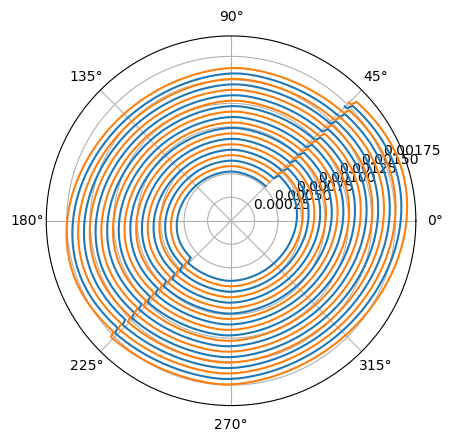

In [123]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(np.array(IDT_data['Theta']).squeeze().T, np.array(IDT_data['R']).squeeze().T)

In [124]:
len(IDT_data['branch0'].exterior.coords)

12696

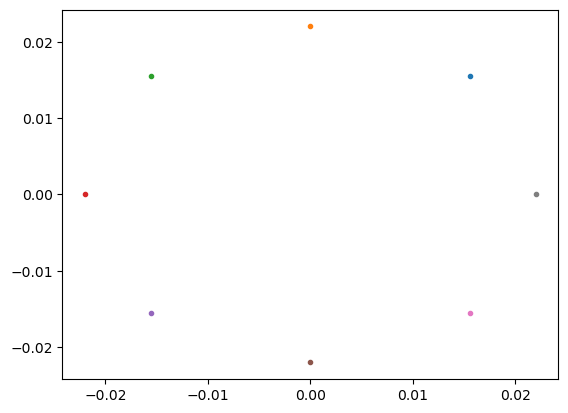

In [125]:
for g in IDT_group['IDT']:
    plt.plot(g['x_offset'],g['y_offset'],'.')

In [126]:
#the IDT is probably too big. Need to check the number of points
print('enter svg filename for the IDT routing')
IDT_gtool.IDTgroup2svg(IDT_group)

with open(IDT_group_dir+'/data.p', 'wb') as fp:
    pickle.dump(IDT_group, fp)


#IDT_groupArray = Polygon2Array(IDT_group)

#savemat(IDT_group_dir+'/data.mat', IDT_groupArray, appendmat=True, format='5', long_field_names=False, do_compression=False, oned_as='row')
IDT_group['route'] = [[],[]]
for IDT_data in IDT_group['IDT']:#do not consider the routes from inkscape
    IDT_group['route'][0].append(IDT_data['electrodes']['elect0'])
    IDT_group['route'][1].append(IDT_data['electrodes']['elect1'])

IDT_gtool.combineIDT_group(IDT_group)

enter svg filename for the IDT routing


In [119]:
IDT_gtool.IDT_group2gds(IDT_group)

#IDT_gtool.IDT_group2svg(IDT_group)

Writing the following cells
Main: Cell ("Main", 64 elements, 0 references)
